In [40]:
"""
Created on Fri Mar 11 10:45:01 2022

@author: leotc
"""

import os 
import matplotlib.pyplot as plt
import numpy as np
import logging

# level of logging to view
logging.basicConfig(level=logging.INFO)

# constants
DPI_SCALE = 2 

# TODO the values here may have changed, please look over and fix in this file and variable_distances.ipynb

In [41]:
dir_path = os.path.abspath('')
logging.debug(f"PATH: {os.path.abspath('')}")
logging.debug(f"PATH CORRECT? {dir_path == os.path.abspath('')}")
logging.debug(f'New path: {dir_path + "/../Data/Camera Images/calibrated star data.txt"}')
with open(dir_path + "/../Data/Camera Images/calibrated star data.txt", "r") as totalpoints:    
    pointdata = totalpoints.readlines()[1:]

In [42]:
# convert flux and distance to absolute magnitudes
def toAbsMag(flux, dist):
    return -(np.log(flux) + 2*np.log(dist))

def period_lum_uncert(star_periods, star_mag, xerr, yerr, runs = 1000):
    """
    Function for calculating the uncertainty in period luminosity relation for stars using monte carlo method
    
    Inputs: star_periods <list>: list of star periods
            star_mag <list>: list of absolute star magnitudes
            xerr <list>: list of uncertainties in period values
            yerr <list>: list of uncertainties in abs magnitude values    
            runs <int>: number of monte carlo iterations to perform, default = 1000
    
    Returns: <tuple>: uncertainty in relation gradient and y-intercept (standard deviation of both)
    """
    np.random.seed(1001)
    
    var_m = []
    var_c = []
    
    for i in range(runs):
        # add random error to each flux term based on uniform distribution of uncertainties
        star_mag_jitter = star_mag + ([a*b for a,b in zip(star_mag, yerr*np.random.uniform(low=-1, high=1, size=len(yerr)))])
        star_periods_jitter = star_periods + ([a*b for a,b in zip(star_periods, xerr*np.random.uniform(low=-1, high=1, size=len(xerr)))])

        poly_fit = np.polyfit(star_periods_jitter, star_mag_jitter, 1)
        var_m.append(poly_fit[0])
        var_c.append(poly_fit[1])
    
    # return standard deviation of simulation as uncertainty
    return np.std(var_m), np.std(var_c)

In [43]:
distance = []
periods = []
luminosities = []

for i in pointdata:
    
    i = i.split()
    period = float(i[-3])
    green_flux = float(i[4])
    dist = float(i[-4])
    
    if period != 0: 
        periods.append(period)
        abs_mag = toAbsMag(green_flux,dist)
        luminosities.append(abs_mag)

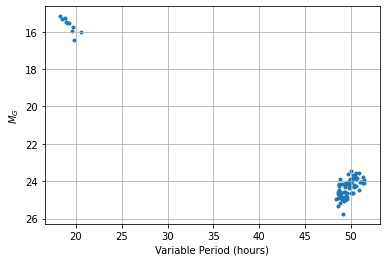

In [59]:
MP_fig, MP_ax = plt.subplots(1,1)
MP_ax.scatter(periods, luminosities, marker='.')
# TODO label the variable stars as in HR diagrams?
MP_ax.set_xlabel('Variable Period (hours)')
MP_ax.set_ylabel('$M_G$')
MP_ax.grid()
MP_ax.invert_yaxis()
MP_fig.savefig(dir_path + "/Magnitude-Period.png", dpi=DPI_SCALE*100)
MP_fig.savefig(dir_path + "/Magnitude-Period.pdf", dpi=DPI_SCALE*100, bbox_inches='tight', pad_inches = 0.01)

- Distance uncertainty: <br />
# $ \Delta D = D^{2}*\Delta\theta $ <br />
- Absolute Magnitude uncertainty:
# $ \Delta Abs Mag = \sqrt{(\frac{\Delta F_{green}}{2.3})^{2}+(\frac{2D\Delta\theta}{2.3})^{2}} $ <br />
- Note: <br />
# $ \Delta\theta = 0.001 arcsec $ 
# $ \Delta F_{green} = 0.015 W/m^{2}/nm $ 





# Long Periods

In [45]:
distance = []
long_periods = []
long_luminosity = []
long_yerr = []
long_xerr = []

for i in pointdata:
    
    i = i.split()
    period = float(i[-3])
    green_flux = float(i[4])
    dist = float(i[-4])
    x_uncert = float(i[-2])
    
    if float(period) > 35:
        long_xerr.append(x_uncert)
        long_periods.append(period)
        abs_mag = toAbsMag(green_flux, dist)
        # compute and append uncertainty in luminosity
        # ?: @leotc can you confirm if that's what this is doing? Delete this line if it is.
        long_yerr.append(((0.015/2.3)**2+((2*dist*0.001)**2))**(1/2)) 
        long_luminosity.append(abs_mag)

In [46]:
# Create a fitting linear model to the data
long_fit = np.polyfit(long_periods, long_luminosity, 1)
long_poly = np.poly1d(long_fit)
logging.info(f"Long period polynomial: {long_poly}")

INFO:root:Long period polynomial:  
-0.3416 x + 41.32


In [47]:
# Compute uncertainty in the model
period_lum_uncert(long_periods, long_luminosity, long_xerr, long_yerr)

(0.010215912742946006, 0.5075431026562873)

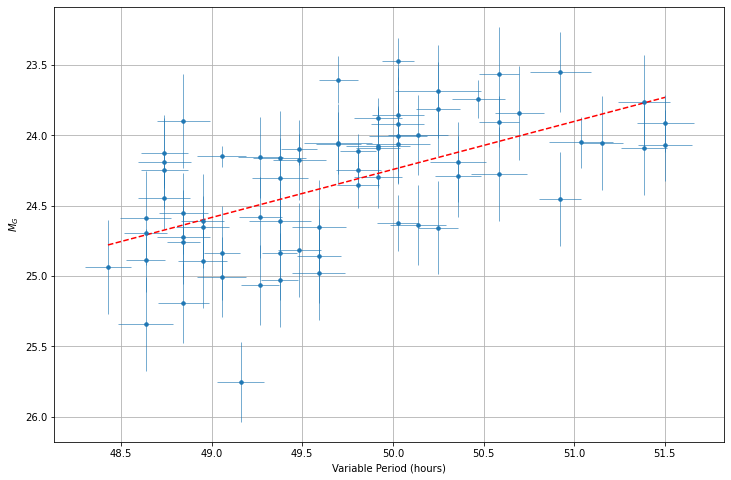

In [56]:
# plot the model 
fig1, ax1 = plt.subplots(figsize=(12,8))
x = np.linspace(min(long_periods), max(long_periods), len(long_periods))
ax1.errorbar(long_periods, long_luminosity, yerr=long_yerr, xerr=long_xerr, fmt='.', markersize='7', elinewidth=0.6)
ax1.plot(x, long_poly(x), "r--")
ax1.grid()
ax1.invert_yaxis()
ax1.set_xlabel('Variable Period (hours)')
ax1.set_ylabel('$M_G$')
# commenting out the following line for the time being, since the plot has changed
# plt.text(50.2,-11.3,"M = 0.148\u00B10.004*P - 17.9\u00B10.2", fontsize='x-large')

fig1.savefig(dir_path + "/Magnitude-Period-highPeriodTrend.png", dpi=DPI_SCALE*100)
fig1.savefig(dir_path + "/Magnitude-Period-highPeriodTrend.pdf", dpi=DPI_SCALE*100, bbox_inches='tight', pad_inches = 0.01)

- For stars with long periods (~50hrs), the relation is given as: <br />
## $ Abs Mag = 0.148\pm0.004*P - 17.9\pm0.2 $ <br />
- explicitly:
## $ distance_{long}(pc) = \sqrt{\frac{10^{0.148\pm0.004*P (hours) - 17.9\pm0.2}}{green flux (W/m^{2}/nm)}} $

# Short Periods

In [49]:
distance = []
short_periods = []
short_luminosity = []
short_yerr = []
short_xerr = []

for i in pointdata:
    
    i = i.split()
    period = float(i[-3])
    green_flux = float(i[4])
    dist = float(i[-4])
    x_uncert = float(i[-2])
    star_name = str(i[0])
    
    if star_name == 'P00789': # NOTE, this star had no clear period in it's data, was thus excluded 
        continue        
        
    if period < 35 and period != 0:
        short_xerr.append(x_uncert)
        short_periods.append(period)
        abs_mag = toAbsMag(green_flux,dist)
        short_yerr.append(((0.015/2.3)**2+((2*dist*0.001)**2))**(1/2)) 
        short_luminosity.append(abs_mag)

In [50]:
short_fit = np.polyfit(short_periods, short_luminosity, 1)
short_poly = np.poly1d(short_fit)
logging.info(f"Short variable model: {short_poly}")

INFO:root:Short variable model:  
0.6427 x + 3.338


In [51]:
period_lum_uncert(short_periods, short_luminosity, short_xerr, short_yerr)

(0.046697274257363384, 0.891353810225869)

- For stars with short periods (~50hrs), the relation is given as: <br />
## $ Log(Flux) = (-0.28\pm0.02) \cdot P - (1.4\pm0.4) $ <br />
- explicitly:
## $ distance_{short}(\text{pc}) = \sqrt{\frac{10^{(-0.28\pm0.02) \cdot P (\text{hours}) - (1.4\pm0.4)}}{\text{green flux} (\text{W}/\text{m}^{2}/\text{nm})}} $

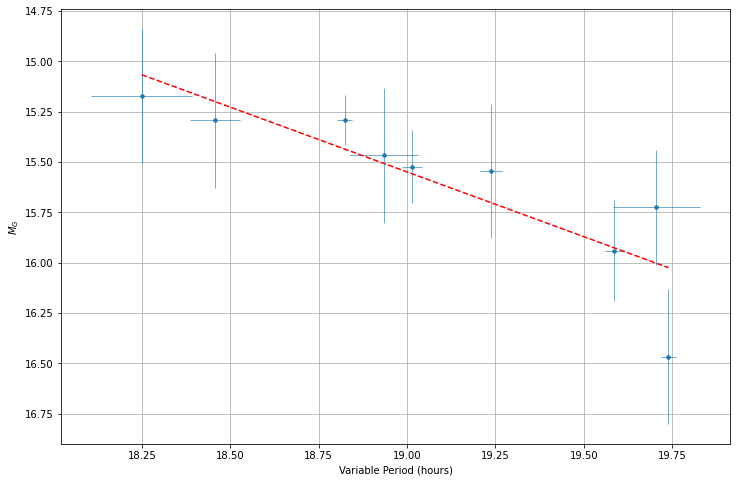

In [57]:
fig2, ax2 = plt.subplots(figsize=(12,8))

x = np.linspace(min(short_periods), max(short_periods), len(short_periods))
ax2.errorbar(short_periods, short_luminosity, yerr=short_yerr, xerr=short_xerr, fmt='.', markersize='7', elinewidth=0.6)
ax2.plot(x,short_poly(x), "r--")
ax2.grid()
ax2.invert_yaxis()
plt.xlabel('Variable Period (hours)')
plt.ylabel('$M_G$') # absolute green magnitudes
# plt.text(18.35,-7.3,"M = -0.28\u00B10.02*P - 1.4\u00B10.4", fontsize='x-large')

fig2.savefig(dir_path + "/Magnitude-Period-lowPeriodTrend.png", dpi=DPI_SCALE*100)
fig2.savefig(dir_path + "/Magnitude-Period-lowPeriodTrend.pdf", dpi=DPI_SCALE*100, bbox_inches='tight', pad_inches = 0.01)
